In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('Reviews.csv')

In [3]:
data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data.shape

(568454, 10)

In [5]:
#to remove the datapoints which are neither positive nor negative
data = data[data['Score']!=3]

In [6]:
data.shape

(525814, 10)

In [7]:
#for score>3, it is 'positive' review and score<3 is 'negative' review
def partition(x):
    if x>3:
        return 'positive'
    else:
        return 'negative'

In [8]:
data['Score'] = data['Score'].apply(partition)

In [9]:
#data.head(5)

In [10]:
sorted_data = data.sort_values(by='ProductId', axis=0)

In [11]:
final = sorted_data.drop_duplicates(subset={"UserId","Time","Text","ProfileName"})
final['Id'].size/sorted_data['Id'].size

0.6925890143662968

In [12]:
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
final_time_sorted = final.sort_values(by = 'Time')

In [14]:
final_time_sorted_1 = final_time_sorted[:10000]

In [15]:
#to clean the text data
import re

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

In [16]:
final_time_sorted_1['Text'] = final_time_sorted_1['Text'].apply(cleanhtml)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
#final_time_sorted_1.head(5)

In [18]:
import string

def cleanpunc(raw_string):
    #print(raw_string)
    newstr = [char for char in raw_string.split() if char not in string.punctuation]
    #print(newstr)
    newstr = ' '.join(newstr)
    return newstr

In [19]:
final_time_sorted_1['Text'] = final_time_sorted_1['Text'].apply(cleanpunc)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
#final_time_sorted_1.head()

In [21]:
final_data = final_time_sorted_1

In [22]:
X_test1 = final_data['Text'][8001:]
y_test = final_data['Score'][8001:]

X_cv1 = final_data['Text'][6401:8000]
y_cv = final_data['Score'][6401:8000]

X_train1 = final_data['Text'][:6400]
y_train = final_data['Score'][:6400]

In [23]:
#bag of words with bigrams
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
#create an object of countvectorizer with bigrams. limit the maximum number of features to 10000 for faster calculation
count_vect = CountVectorizer(ngram_range=(1,2), max_features=10000)

In [25]:
#fit transform the training values to train the model. transform the test and cv values so that there is no data leak
final_bigram_train = count_vect.fit_transform(X_train1.values)
final_bigram_test = count_vect.transform(X_test1.values)
final_bigram_cv = count_vect.transform(X_cv1.values)

In [48]:
final_bigram_train.shape

(6400, 10000)

In [26]:
#standardize the data 
from sklearn.preprocessing import StandardScaler

In [27]:
#create an object for StandardScaler
sc = StandardScaler(with_mean=False)

In [28]:
X_train_standardized = sc.fit_transform(final_bigram_train)
X_test_standardized = sc.transform(final_bigram_test)
X_cv_standarized = sc.transform(final_bigram_cv)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [29]:
#to train the model using KNN.
from sklearn.neighbors import KNeighborsClassifier

In [32]:
#create an object of KNN using default values
Knn = KNeighborsClassifier()

In [35]:
Knn.fit(X_train_standardized, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [37]:
y_pred = Knn.predict(X_test_standardized)

In [38]:
#to measure the performance of the simple model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [39]:
accuracy_score(y_test, y_pred)

0.8834417208604303

In [40]:
confusion_matrix(y_test, y_pred)

array([[   1,  230],
       [   3, 1765]], dtype=int64)

In [42]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   negative       0.25      0.00      0.01       231
   positive       0.88      1.00      0.94      1768

avg / total       0.81      0.88      0.83      1999



In [45]:
#data seems highly imbalanced. 
y_train.value_counts()

positive    5651
negative     749
Name: Score, dtype: int64

In [46]:
y_test.value_counts()

positive    1768
negative     231
Name: Score, dtype: int64

#### conclusion #

The above is a simple model with only 10000 dataset. The dataset is small since it is time consuming to train large dataset. The model gives a good accuracy but it is due imbalanced dataset. All the negative values are classified as positive. Hence the model could be considered as overfit.

Further improvements could be tried by varying the hyper parameter K and selecting the K with best cv accuracy


In [51]:
#create a list of K values and train the model with each K. find the cv error for the each model and compare the accuracy
K_values = [5,11,15,25,49,75,99]
accuracy = []
for k in K_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_standardized, y_train)
    y_pred = knn.predict(X_cv_standarized)
    acc = accuracy_score(y_cv, y_pred)
    accuracy.append(acc)    

In [54]:
max_k =max(accuracy)
print(max_k)

0.9049405878674172


In [55]:
accuracy.index(max_k)

1

In [56]:
#the maximum accuracy is given by K=11

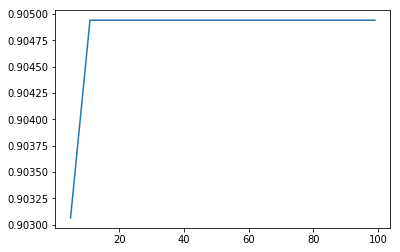

In [58]:
plt.plot(K_values, accuracy)

In [60]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train_standardized,y_train)
y_pred = knn.predict(X_test_standardized)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

0.8844422211105553
[[   0  231]
 [   0 1768]]
             precision    recall  f1-score   support

   negative       0.00      0.00      0.00       231
   positive       0.88      1.00      0.94      1768

avg / total       0.78      0.88      0.83      1999



C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### conclusion
The above method did not yeild a better model as theaccuracy values did not change significantly with the variation of K values.
Hence the model remained overfit due to the imbalanced dataset.

In [61]:
#to improve the model, let us not keep any max_featues in the countvectorizer

In [62]:
count_vect = CountVectorizer(ngram_range=(1,2))
final_bigram_train = count_vect.fit_transform(X_train1.values)
final_bigram_test = count_vect.transform(X_test1.values)
final_bigram_cv = count_vect.transform(X_cv1.values)

In [64]:
final_bigram_train.shape

(6400, 209853)

In [63]:
X_train_standardized = sc.fit_transform(final_bigram_train)
X_test_standardized = sc.transform(final_bigram_test)
X_cv_standarized = sc.transform(final_bigram_cv)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [ ]:
#lets make a simple Knn model for the above newly created training data

In [65]:
knn = KNeighborsClassifier()

In [66]:
knn.fit(X_train_standardized, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [68]:
y_pred = knn.predict(X_test_standardized)

In [69]:
accuracy_score(y_test, y_pred)

0.8844422211105553

In [70]:
confusion_matrix(y_test, y_pred)

array([[   0,  231],
       [   0, 1768]], dtype=int64)

In [71]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00       231
   positive       0.88      1.00      0.94      1768

avg / total       0.78      0.88      0.83      1999



C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


###### conclusion
Here too the issue of imbalance persists and the confusion matrix is heavily skewed towards positive points.

In [72]:
#lets use weights parameter in KNN and check the performance

In [73]:
knn = KNeighborsClassifier(weights = 'distance')

In [74]:
knn.fit(X_train_standardized, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [75]:
y_pred = knn.predict(X_test_standardized)

In [76]:
accuracy_score(y_test, y_pred)

0.8844422211105553

In [77]:
confusion_matrix(y_test, y_pred)

array([[   0,  231],
       [   0, 1768]], dtype=int64)

In [78]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00       231
   positive       0.88      1.00      0.94      1768

avg / total       0.78      0.88      0.83      1999



C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [79]:
#the dsitance paramter weight did not make any difference 

In [80]:
#lets use mahattan distance as parameter and check the accuracy

In [81]:
knn = KNeighborsClassifier(weights = 'distance', p=1)

In [82]:
knn.fit(X_train_standardized, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=1,
           weights='distance')

In [83]:
y_pred = knn.predict(X_test_standardized)

In [84]:
accuracy_score(y_test, y_pred)

0.8844422211105553

In [85]:
confusion_matrix(y_test, y_pred)

array([[   0,  231],
       [   0, 1768]], dtype=int64)

In [86]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00       231
   positive       0.88      1.00      0.94      1768

avg / total       0.78      0.88      0.83      1999



C:\Users\user\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### conclusion
The data was vectorized using count vectorizer and KNN has been applied. Due to the data imbalance, the results are found to be poor.